In [1]:
from ipyleaflet import (Map, GeoData, basemaps, WidgetControl, GeoJSON,
                        LayersControl, Icon, Marker,basemap_to_tiles, Choropleth,
                        MarkerCluster, Heatmap,SearchControl, 
                        FullScreenControl)

from ipywidgets import Text, HTML
from branca.colormap import linear
import geopandas as gpd
import pandas as pd
import json
from dotenv import load_dotenv
load_dotenv()
import requests
from requests.auth import HTTPBasicAuth
import os
from shapely.geometry import Point
from geopandas.tools import sjoin

In [2]:
url = os.getenv('COUCHDB_URL')+"/bike_locations/_design/datetime_doc/_view/datetime-index?limit=10000&include_docs=true&descending=true"

payload={}
response = requests.get(url, data=payload, auth=HTTPBasicAuth(os.getenv('COUCHDB_USER'), os.getenv('COUCHDB_PASSWORD')))

data = [row['doc'] for row in response.json()['rows']]
for d in data:
    d.pop('_id', None)
    d.pop('_rev', None)
bike_locations_df = pd.DataFrame(data)
bike_locations=gpd.GeoDataFrame(bike_locations_df, crs=4326, geometry=gpd.points_from_xy(bike_locations_df.lon, bike_locations_df.lat))
bike_locations.drop(columns=['lat', 'lon'],inplace=True)
print(len(bike_locations.index))
bike_locations.head()

10000


,id,datetime,geometry
0,YVO:Vehicle:fda2ce0f-eda9-4138-b953-b38e65db945a,2021-12-15T18:45:12.509Z,POINT (10.74863 59.95520)
1,YVO:Vehicle:dc812310-c65a-4713-8c64-5dd1c80d76a5,2021-12-15T18:45:12.508Z,POINT (10.80045 59.93354)
2,YLI:Vehicle:RQLAB546RHCAT,2021-12-15T18:45:12.506Z,POINT (10.73661 59.91328)
3,YTI:Vehicle:2010b8868b9d0baea55ec11ee2227bcb8e...,2021-12-15T18:45:12.504Z,POINT (10.71903 59.92335)
4,YVO:Vehicle:3f9907c2-5891-4ffa-af1b-06a0e8463ee5,2021-12-15T18:45:12.502Z,POINT (10.70373 59.91853)


In [3]:
bike_locations[['operator','id_temp']] = bike_locations['id'].str.split(':', 1, expand=True)
bike_locations.drop(columns=['id_temp'])
bike_locations.head(2)


,id,datetime,geometry,operator,id_temp
0,YVO:Vehicle:fda2ce0f-eda9-4138-b953-b38e65db945a,2021-12-15T18:45:12.509Z,POINT (10.74863 59.95520),YVO,Vehicle:fda2ce0f-eda9-4138-b953-b38e65db945a
1,YVO:Vehicle:dc812310-c65a-4713-8c64-5dd1c80d76a5,2021-12-15T18:45:12.508Z,POINT (10.80045 59.93354),YVO,Vehicle:dc812310-c65a-4713-8c64-5dd1c80d76a5


In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country =  world[world.name == "Norway"]
print(len(country.index))
country.head()

1


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
21,5320045,Europe,Norway,-99,364700.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."


In [5]:
bikes_in_country = sjoin(bike_locations,country, how='inner')
bikes_in_country.head()

,id,datetime,geometry,operator,id_temp,index_right,pop_est,continent,name,iso_a3,gdp_md_est
0,YVO:Vehicle:fda2ce0f-eda9-4138-b953-b38e65db945a,2021-12-15T18:45:12.509Z,POINT (10.74863 59.95520),YVO,Vehicle:fda2ce0f-eda9-4138-b953-b38e65db945a,21,5320045,Europe,Norway,-99,364700.0
1,YVO:Vehicle:dc812310-c65a-4713-8c64-5dd1c80d76a5,2021-12-15T18:45:12.508Z,POINT (10.80045 59.93354),YVO,Vehicle:dc812310-c65a-4713-8c64-5dd1c80d76a5,21,5320045,Europe,Norway,-99,364700.0
2,YLI:Vehicle:RQLAB546RHCAT,2021-12-15T18:45:12.506Z,POINT (10.73661 59.91328),YLI,Vehicle:RQLAB546RHCAT,21,5320045,Europe,Norway,-99,364700.0
3,YTI:Vehicle:2010b8868b9d0baea55ec11ee2227bcb8e...,2021-12-15T18:45:12.504Z,POINT (10.71903 59.92335),YTI,Vehicle:2010b8868b9d0baea55ec11ee2227bcb8e1af2...,21,5320045,Europe,Norway,-99,364700.0
4,YVO:Vehicle:3f9907c2-5891-4ffa-af1b-06a0e8463ee5,2021-12-15T18:45:12.502Z,POINT (10.70373 59.91853),YVO,Vehicle:3f9907c2-5891-4ffa-af1b-06a0e8463ee5,21,5320045,Europe,Norway,-99,364700.0


<AxesSubplot:>

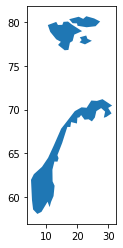

In [6]:
country.plot()

## Base maps, Markers & Icons


<AxesSubplot:>

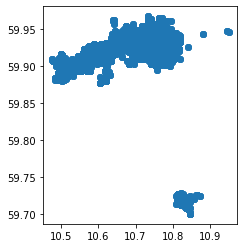

In [7]:
bikes_in_country.plot()

In [8]:
bydeler=gpd.read_file('oslo_bydeler/bydeler_xls.shp')
bydeler.head()

,cartodb_id,name,descriptio,timestamp,begin,_end,altitudemo,tessellate,extrude,visibility,...,bydel,objtype,streng,kdata_dato,kdata_orig,kdata_omr,vert_datum,shape_leng,shape_area,geometry
0,9,kml_9,<center><table><tr><th colspan='2' align='cent...,None,None,None,None,-1,4,-1,...,Ullern,Bydelsgrense,Bydel Ullern,20/01/2013,"PBE, Oslo kommune",301,NN2000,15724.5663841,9765788.18778,"POLYGON ((10.70866 59.93147, 10.70859 59.93138..."
1,15,kml_15,<center><table><tr><th colspan='2' align='cent...,None,None,None,None,-1,1,-1,...,Stovner,Bydelsgrense,Bydel Stovner,20/01/2013,"PBE, Oslo kommune",301,NN2000,15327.7416977,8250401.94141,"POLYGON ((10.93152 59.93635, 10.93105 59.93652..."
2,16,kml_16,<center><table><tr><th colspan='2' align='cent...,None,None,None,None,-1,4,-1,...,Vestre Aker,Bydelsgrense,Bydel Vestre Aker,20/01/2013,"PBE, Oslo kommune",301,NN2000,27083.9673185,16564208.0511,"POLYGON ((10.71549 59.95762, 10.71551 59.95756..."
3,17,kml_17,<center><table><tr><th colspan='2' align='cent...,None,None,None,None,-1,1,-1,...,Grorud,Bydelsgrense,Bydel Grorud,20/01/2013,"PBE, Oslo kommune",301,NN2000,23623.3316795,7046270.14119,"POLYGON ((10.92832 59.97972, 10.92828 59.97953..."
4,1,kml_1,<center><table><tr><th colspan='2' align='cent...,None,None,None,None,-1,1,-1,...,Søndre Nordstrand,Bydelsgrense,Bydel Søndre Nordstrand,20/01/2013,"PBE, Oslo kommune",301,NN2000,31335.3969187,20106672.2461,"POLYGON ((10.89036 59.81765, 10.89033 59.81763..."


<AxesSubplot:>

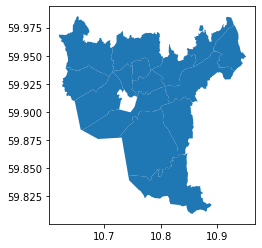

In [9]:
bydeler.plot()

In [10]:
bikes_in_oslo = sjoin(bike_locations,bydeler, how='left')
bikes_in_oslo.head()

,id,datetime,geometry,operator,id_temp,index_right,cartodb_id,name,descriptio,timestamp,...,x,bydel,objtype,streng,kdata_dato,kdata_orig,kdata_omr,vert_datum,shape_leng,shape_area
0,YVO:Vehicle:fda2ce0f-eda9-4138-b953-b38e65db945a,2021-12-15T18:45:12.509Z,POINT (10.74863 59.95520),YVO,Vehicle:fda2ce0f-eda9-4138-b953-b38e65db945a,9.0,14.0,kml_14,<center><table><tr><th colspan='2' align='cent...,None,...,Bydel,Nordre Aker,Bydelsgrense,Bydel Nordre Aker,20/01/2013,"PBE, Oslo kommune",301,NN2000,23378.7231815,13687408.0016
1,YVO:Vehicle:dc812310-c65a-4713-8c64-5dd1c80d76a5,2021-12-15T18:45:12.508Z,POINT (10.80045 59.93354),YVO,Vehicle:dc812310-c65a-4713-8c64-5dd1c80d76a5,14.0,13.0,kml_13,<center><table><tr><th colspan='2' align='cent...,None,...,Bydel,Bjerke,Bydelsgrense,Bydel Bjerke,20/01/2013,"PBE, Oslo kommune",301,NN2000,16790.6600819,7924521.39455
2,YLI:Vehicle:RQLAB546RHCAT,2021-12-15T18:45:12.506Z,POINT (10.73661 59.91328),YLI,Vehicle:RQLAB546RHCAT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YTI:Vehicle:2010b8868b9d0baea55ec11ee2227bcb8e...,2021-12-15T18:45:12.504Z,POINT (10.71903 59.92335),YTI,Vehicle:2010b8868b9d0baea55ec11ee2227bcb8e1af2...,10.0,6.0,kml_6,<center><table><tr><th colspan='2' align='cent...,None,...,Bydel,Frogner,Bydelsgrense,Bydel Frogner,20/01/2013,"PBE, Oslo kommune",301,NN2000,19146.4080361,14038617.7818
4,YVO:Vehicle:3f9907c2-5891-4ffa-af1b-06a0e8463ee5,2021-12-15T18:45:12.502Z,POINT (10.70373 59.91853),YVO,Vehicle:3f9907c2-5891-4ffa-af1b-06a0e8463ee5,10.0,6.0,kml_6,<center><table><tr><th colspan='2' align='cent...,None,...,Bydel,Frogner,Bydelsgrense,Bydel Frogner,20/01/2013,"PBE, Oslo kommune",301,NN2000,19146.4080361,14038617.7818


In [11]:
bydeler_with_bikes = sjoin(bydeler,bike_locations, how='inner')

bydeler_with_bikes.head()

,cartodb_id,name,descriptio,timestamp,begin,_end,altitudemo,tessellate,extrude,visibility,...,kdata_omr,vert_datum,shape_leng,shape_area,geometry,index_right,id,datetime,operator,id_temp
0,9,kml_9,<center><table><tr><th colspan='2' align='cent...,None,None,None,None,-1,4,-1,...,301,NN2000,15724.5663841,9765788.18778,"POLYGON ((10.70866 59.93147, 10.70859 59.93138...",5218,YTI:Vehicle:bd253f828b351fc5e31392008e69e06fb0...,2021-12-15T18:30:07.453Z,YTI,Vehicle:bd253f828b351fc5e31392008e69e06fb0f2df...
0,9,kml_9,<center><table><tr><th colspan='2' align='cent...,None,None,None,None,-1,4,-1,...,301,NN2000,15724.5663841,9765788.18778,"POLYGON ((10.70866 59.93147, 10.70859 59.93138...",2284,YTI:Vehicle:bd253f828b351fc5e31392008e69e06fb0...,2021-12-15T18:45:07.881Z,YTI,Vehicle:bd253f828b351fc5e31392008e69e06fb0f2df...
0,9,kml_9,<center><table><tr><th colspan='2' align='cent...,None,None,None,None,-1,4,-1,...,301,NN2000,15724.5663841,9765788.18778,"POLYGON ((10.70866 59.93147, 10.70859 59.93138...",8143,YTI:Vehicle:bd253f828b351fc5e31392008e69e06fb0...,2021-12-15T18:15:09.275Z,YTI,Vehicle:bd253f828b351fc5e31392008e69e06fb0f2df...
0,9,kml_9,<center><table><tr><th colspan='2' align='cent...,None,None,None,None,-1,4,-1,...,301,NN2000,15724.5663841,9765788.18778,"POLYGON ((10.70866 59.93147, 10.70859 59.93138...",4158,YVO:Vehicle:37fee265-5bc2-49ff-9a76-f6f3db3c4f74,2021-12-15T18:30:09.708Z,YVO,Vehicle:37fee265-5bc2-49ff-9a76-f6f3db3c4f74
0,9,kml_9,<center><table><tr><th colspan='2' align='cent...,None,None,None,None,-1,4,-1,...,301,NN2000,15724.5663841,9765788.18778,"POLYGON ((10.70866 59.93147, 10.70859 59.93138...",7089,YVO:Vehicle:37fee265-5bc2-49ff-9a76-f6f3db3c4f74,2021-12-15T18:15:11.575Z,YVO,Vehicle:37fee265-5bc2-49ff-9a76-f6f3db3c4f74


In [12]:
bike_count_per_bydel=bydeler_with_bikes.groupby('streng')['streng'].value_counts()
bike_count_per_bydel.head()

streng             streng           
Bydel Alna         Bydel Alna             45
Bydel Bjerke       Bydel Bjerke          196
Bydel Frogner      Bydel Frogner        1121
Bydel Gamle Oslo   Bydel Gamle Oslo     1142
Bydel Grünerløkka  Bydel Grünerløkka    1240
Name: streng, dtype: int64

In [13]:
dfsjoin = gpd.sjoin(bydeler, bike_locations) #Spatial join Points to polygons
dfpivot = pd.pivot_table(dfsjoin,index='streng',columns='operator',aggfunc={'id':len})
dfpivot.columns = dfpivot.columns.droplevel()

dfpolynew = bydeler.merge(dfpivot, how='left', on='streng').fillna(0)
dfpolynew.head(5)

,cartodb_id,name,descriptio,timestamp,begin,_end,altitudemo,tessellate,extrude,visibility,...,kdata_dato,kdata_orig,kdata_omr,vert_datum,shape_leng,shape_area,geometry,YLI,YTI,YVO
0,9,kml_9,<center><table><tr><th colspan='2' align='cent...,0,0,0,0,-1,4,-1,...,20/01/2013,"PBE, Oslo kommune",301,NN2000,15724.5663841,9765788.18778,"POLYGON ((10.70866 59.93147, 10.70859 59.93138...",23.0,176.0,233.0
1,15,kml_15,<center><table><tr><th colspan='2' align='cent...,0,0,0,0,-1,1,-1,...,20/01/2013,"PBE, Oslo kommune",301,NN2000,15327.7416977,8250401.94141,"POLYGON ((10.93152 59.93635, 10.93105 59.93652...",0.0,0.0,0.0
2,16,kml_16,<center><table><tr><th colspan='2' align='cent...,0,0,0,0,-1,4,-1,...,20/01/2013,"PBE, Oslo kommune",301,NN2000,27083.9673185,16564208.0511,"POLYGON ((10.71549 59.95762, 10.71551 59.95756...",10.0,92.0,211.0
3,17,kml_17,<center><table><tr><th colspan='2' align='cent...,0,0,0,0,-1,1,-1,...,20/01/2013,"PBE, Oslo kommune",301,NN2000,23623.3316795,7046270.14119,"POLYGON ((10.92832 59.97972, 10.92828 59.97953...",0.0,0.0,0.0
4,1,kml_1,<center><table><tr><th colspan='2' align='cent...,0,0,0,0,-1,1,-1,...,20/01/2013,"PBE, Oslo kommune",301,NN2000,31335.3969187,20106672.2461,"POLYGON ((10.89036 59.81765, 10.89033 59.81763...",0.0,0.0,0.0


In [14]:
max_count=dfpolynew[["YLI","YTI","YVO"]].max().max()
max_count

685.0

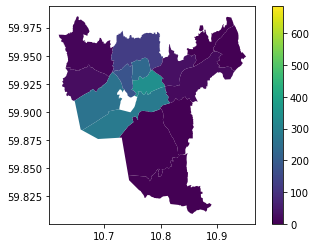

In [15]:
dfpolynew.plot(column='YLI',legend=True,vmax=max_count);

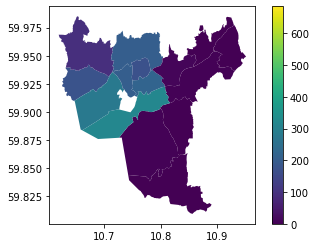

In [18]:
dfpolynew.plot(column='YTI',legend=True,vmax=max_count);

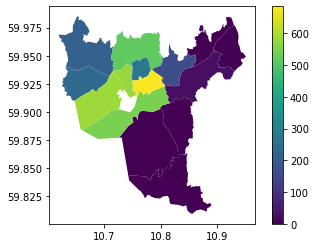

In [17]:
dfpolynew.plot(column='YVO',legend=True,vmax=max_count);